In [125]:
import sys
import time
import json
import requests
import warnings
import importlib
import numpy as np
import pandas as pd
import pickle as pkl
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import matplotlib.pyplot as plt

import h3
import h3pandas

import src
from src.reload import deep_reload
from src.process_nhts_data import Itinerary

from pathlib import Path

In [145]:
#Parsing keys
deep_reload(src)
keys_dict=src.keys_parser.Parse()
keys_dict

{'afdc_key': 'HGPBj8jd5JT96ixLhRl8wP970Ux3WHDZbye7EIrr',
 'bing_maps_key': 'AsqO6CWBgTU-V6TLXXLAeU8nSUTVteIE5bc5zbmCVanvaVhR7zF9if18dVKnh0WD',
 'mapbox_key': 'pk.eyJ1IjoiYWlyYWJpbm8iLCJhIjoiY2wzZGR3cHZ3MDdpbzNqcXBxZ2RvZXV0dSJ9.5SgDnIFa2heDP27DTC0L7g'}

In [2]:
'''
generating demographic data GeoDataFrame for Colorado using src.pull_data
 - this writes a .pkl in Data/Generated_Data
 - can also be called from the command line
'''
deep_reload(src)
if Path('Data/Generated_Data/Census_Tract_Demographic_Data_08.pkl').is_file():
    pass
else:
    src.pull_data.PullData(state_FIPS='08',path_to_data='Data/')

In [3]:
#Loading in the demographic data generated using src.pull_data
deep_reload(src)
acs_gdf=src.pull_data.LoadACSData('Data/Generated_Data/Census_Tract_Demographic_Data_08.pkl')

In [4]:
#Down-selecting by proximity to central Denver (25 km radius)
deep_reload(src)
lon=-104.989079
lat=39.779970
radius=25000
#Data for selected tracts
gdf_selected=src.calculations.DownSlectBlocks(acs_gdf,lon,lat,radius)
#Background for plotting
gdf_background=src.calculations.DownSlectBlocks(acs_gdf,lon,lat,radius*3)

In [5]:
#Making empty H3 hex cells to match the census tracts (https://h3geo.org/, https://pypi.org/project/h3/, https://pypi.org/project/h3pandas/)
#Using resolution 8
deep_reload(src)
gdf_hex_8=src.h3_hex.MakeEmptyHex(gdf_selected,resolution=8)

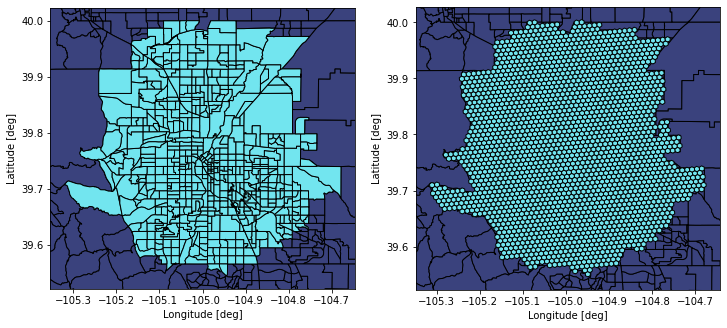

In [6]:
#Plot showing census tracks and H3 Hex
deep_reload(src)
fig=src.figures.TractsHexComparisonPlot(gdf_selected,gdf_hex_8,gdf_background)

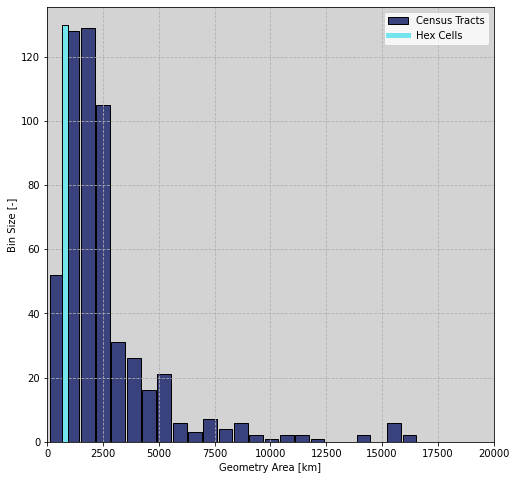

In [7]:
#Comparing sizes of tracts to hex cells
deep_reload(src)
fig=src.figures.TractsHexAreaHistogram(gdf_selected,gdf_hex_8)

In [8]:
#Converting demographic data to H3 cells for calculations
deep_reload(src)
default_interpolation_keys=['Total_Housing','Owned', '1 Owned', '2 to 4 Owned',
        '5+ Owned', 'Mobile Home Owned',
        'Other Owned', 'Rented', '1 Rented', '2 to 4 Rented', '5+ Rented',
        'Mobile Home Rented', 'Other Rented', 'Total_Race',
        'White Alone', 'Black or African American Alone',
        'American Indian and Alaska Native Alone', 'Asian Alone',
        'Native Hawaiian and Other Pacific Islander Alone',
        'Some Other Race Alone', 'Two or More Races']

default_keep_closest_keys=['Median Income']
gdf_hex_data=src.h3_hex.DataToHex(gdf_selected,gdf_hex_8,interpolation_keys=default_interpolation_keys,
    keep_closest_keys=default_keep_closest_keys)

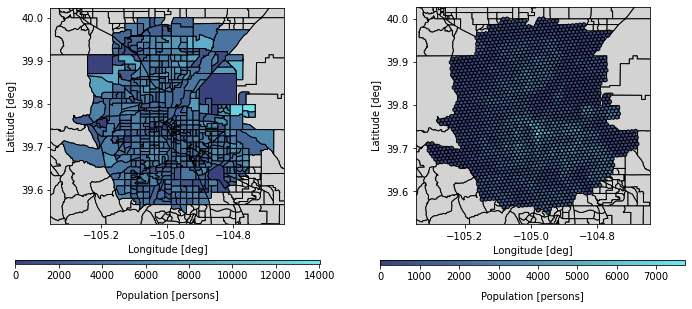

In [9]:
#Comparing population to hex cells
deep_reload(src)
fig=src.figures.DataColumnComparisonPlot(gdf_selected,gdf_hex_data,gdf_background,
                               column='Total_Housing',
                               color_axis_label='Population [persons]',
                               colors=np.flip(src.figures.color_scheme_2_1))

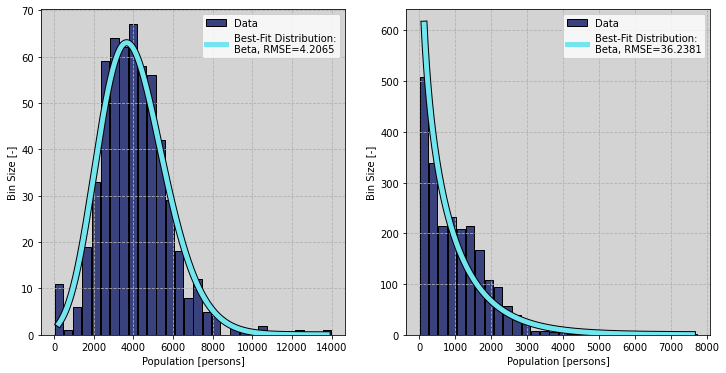

In [10]:
deep_reload(src)
fig=src.figures.HistogramComparisonPlot(gdf_selected,gdf_hex_data,column=['Total_Housing'],data_label='Population [persons]',bins=30)

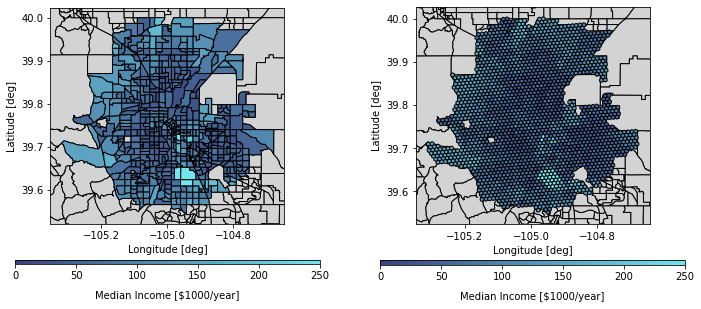

In [11]:
#Comparing median income to hex cells
deep_reload(src)
gdf_selected['Median Income 1000']=gdf_selected['Median Income']/1000
gdf_hex_data['Median Income 1000']=gdf_hex_data['Median Income']/1000
fig=src.figures.DataColumnComparisonPlot(gdf_selected,gdf_hex_data,gdf_background,
                               column='Median Income 1000',
                               color_axis_label='Median Income [$1000/year]',
                               colors=np.flip(src.figures.color_scheme_2_1))

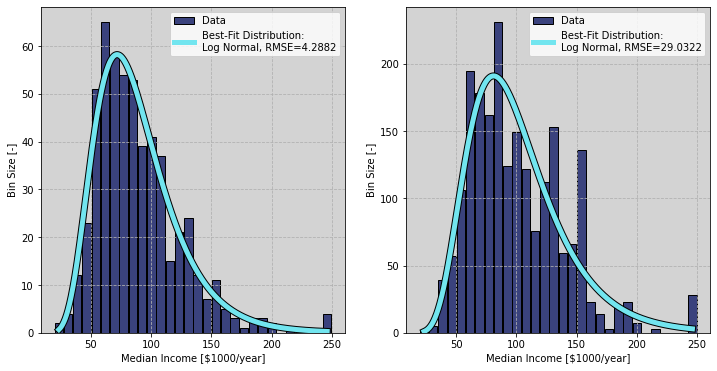

In [12]:
deep_reload(src)
fig=src.figures.HistogramComparisonPlot(gdf_selected,gdf_hex_data,column=['Median Income 1000'],data_label='Median Income [$1000/year]',bins=30)

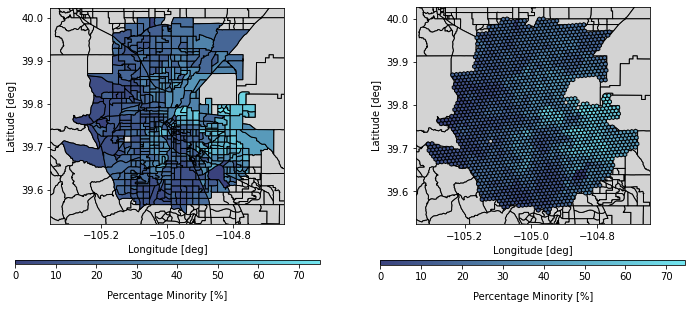

In [13]:
#Comparing percentage of minority residents to hex cells
deep_reload(src)
gdf_selected['Minority Percentage']=(gdf_selected['Total_Race']-gdf_selected['White Alone'])/gdf_selected['Total_Race']*100
gdf_hex_data['Minority Percentage']=(gdf_hex_data['Total_Race']-gdf_hex_data['White Alone'])/gdf_hex_data['Total_Race']*100
fig=src.figures.DataColumnComparisonPlot(gdf_selected,gdf_hex_data,gdf_background,
                               column='Minority Percentage',
                               color_axis_label='Percentage Minority [%]',
                               colors=np.flip(src.figures.color_scheme_2_1))

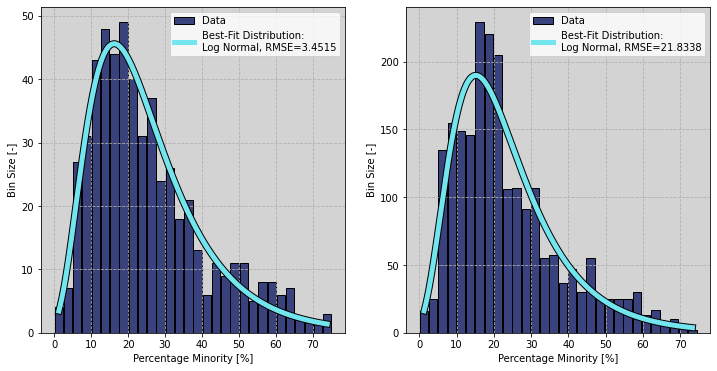

In [14]:
deep_reload(src)
fig=src.figures.HistogramComparisonPlot(gdf_selected,gdf_hex_data,column=['Minority Percentage'],data_label='Percentage Minority [%]',bins=30)

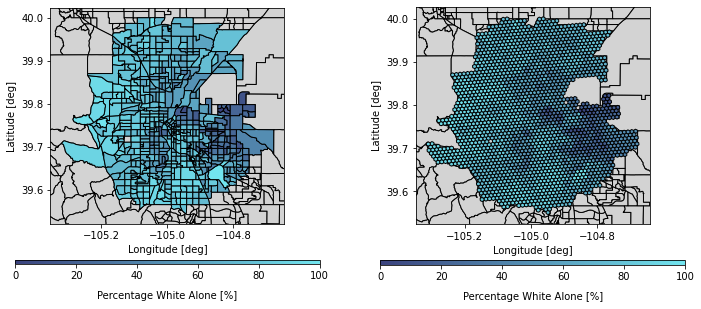

In [15]:
#Comparing percentage of white residents to hex cells
deep_reload(src)
gdf_selected['White Alone Percentage']=(gdf_selected['White Alone'])/gdf_selected['Total_Race']*100
gdf_hex_data['White Alone Percentage']=(gdf_hex_data['White Alone'])/gdf_hex_data['Total_Race']*100
fig=src.figures.DataColumnComparisonPlot(gdf_selected,gdf_hex_data,gdf_background,
                               column='White Alone Percentage',
                               color_axis_label='Percentage White Alone [%]',
                               colors=np.flip(src.figures.color_scheme_2_1))

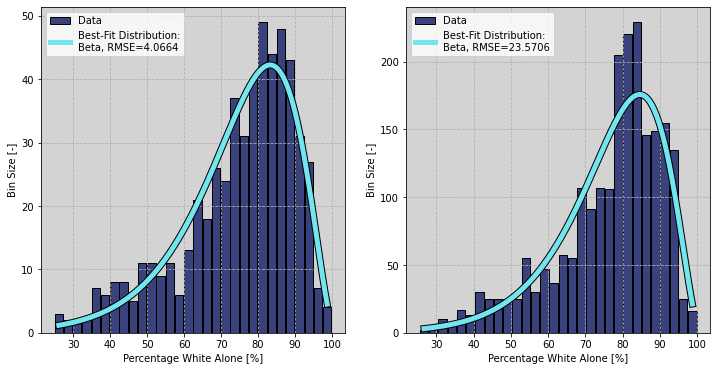

In [16]:
deep_reload(src)
fig=src.figures.HistogramComparisonPlot(gdf_selected,gdf_hex_data,column=['White Alone Percentage'],data_label='Percentage White Alone [%]',bins=30)

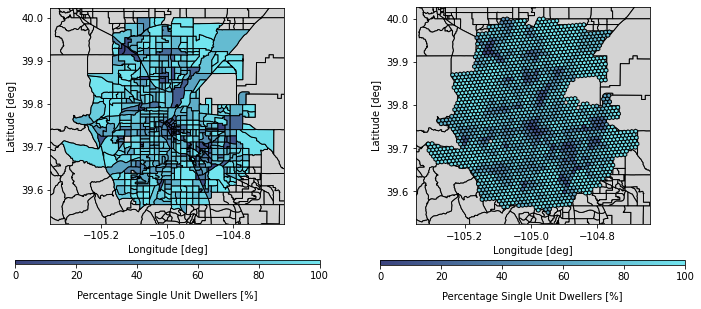

In [17]:
#Comparing percentage of single unit dwellers to hex cells
deep_reload(src)
gdf_selected['Single Unit Percentage']=(gdf_selected['1 Owned']+gdf_selected['1 Rented'])/gdf_selected['Total_Housing']*100
gdf_hex_data['Single Unit Percentage']=(gdf_hex_data['1 Owned']+gdf_hex_data['1 Rented'])/gdf_hex_data['Total_Housing']*100
fig=src.figures.DataColumnComparisonPlot(gdf_selected,gdf_hex_data,gdf_background,
                               column='Single Unit Percentage',
                               color_axis_label='Percentage Single Unit Dwellers [%]',
                               colors=np.flip(src.figures.color_scheme_2_1))

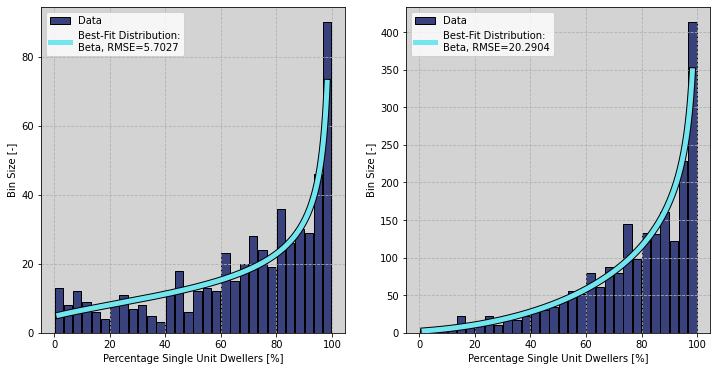

In [18]:
deep_reload(src)
fig=src.figures.HistogramComparisonPlot(gdf_selected,gdf_hex_data,column='Single Unit Percentage',data_label='Percentage Single Unit Dwellers [%]',bins=30)

In [19]:
#Loading in the NHTS data to make itineraries
deep_reload(src)
NHTS_df=src.process_nhts_data.LoadNHTSData('Data/NHTS_2017/trippub.csv')

In [20]:
#Processing itineraries for the NHTS data
if Path('Data/Generated_Data/NHTS_Itineraries.pkl').is_file():
    pass
else:
    NHTS_itineraries=src.process_nhts_data.CreateItineraries(NHTS_df)

In [21]:
#Loading the NHTS Data
deep_reload(src)
itin=pkl.load(open('Data/Generated_Data/NHTS_Itineraries.pkl','rb'))

In [22]:
#Creating datasets for National, Colorado, and Denver MSA
itin_national=itin
itin_colorado=src.process_nhts_data.FilterByAttribute(itin_national,'hh_state','8')
itin_denver_msa=src.process_nhts_data.FilterByAttribute(itin_national,'hh_msa','19740')

100%|██████████| 153351/153351 [00:00<00:00, 1415186.20it/s]


Itinerary 112010 simulated in 4.2301 seconds


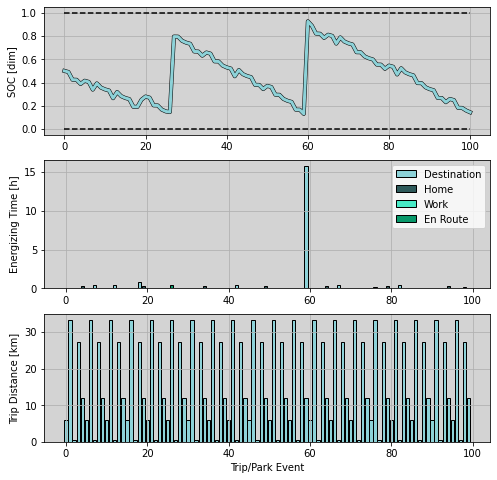

In [25]:
#Demonstration optimal charge scheduling run
deep_reload(src)
n=np.random.randint(0,len(itin_national)-1)
n=112010
t0=time.time()
veh=src.simulation.BEV_Compiled(itin_national[n])
strategy,cost_to_go=veh.Optimize()
control,soc,sic=veh.Evaluate(strategy)
print('Itinerary {} simulated in {:.4f} seconds'.format(n,time.time()-t0))
fig=src.figures.EVTracePlot(veh,control,soc,max_dwells_disp=100,colors=np.flip(src.figures.color_scheme_4_1))

In [27]:
#Running experiment for Denver MSA - can also be done from command line
deep_reload(src)
df_out=src.designed_experiment.Run(itin_denver_msa)

Running Experiment


100%|██████████| 324/324 [08:48<00:00,  1.63s/it]

Consolidating Results


In [36]:
#Saving Data
pkl.dump(df_out,open('Data/Generated_Data/Experiment_Results_Denver_MSA.pkl','wb'))

In [39]:
#Producing regression results
deep_reload(src)
model,df_norm,data,maxes,mins=src.sic_formulae.ProduceRegressionResults(df_out)

In [43]:
#Showing model ANOVA
deep_reload(src)
src.sic_formulae.ModelANOVA(model,df_norm,6)

{'R': 0.9973026389516273,
 'RSquared': 0.9946125536598798,
 'AdjustedRSquared': 0.9932812927881899,
 'StdError': 3.350430679334388e-05,
 'SSE': 0.03806219380809725,
 'SSM': 7.026916537330054,
 'SST': 7.064978731138132,
 'DFM': 63,
 'DFE': 260,
 'DFT': 323,
 'MSM': 0.11153835773539769,
 'MSE': 0.00014639305310806634,
 'MST': 0.021872999167610315,
 'F': 761.9101819883546,
 'P(F)': 6.412488314617118e-263}

In [48]:
#Printing significant model parameters in LaTeX tabular
deep_reload(src)
src.sic_formulae.PrintLaTeXTabular(model,alpha=.01)

\hline Coefficient & Value & t-value & p-value \\
\hline {\small Intercept } & 0.204 & 24.257 & 0.000 \\
\hline {\small HC } & -0.191 & -16.096 & 0.000 \\
\hline {\small WC } & -0.080 & -6.750 & 0.000 \\
\hline {\small DCL } & -0.065 & -4.968 & 0.000 \\
\hline {\small HC:WC } & 0.076 & 4.500 & 0.000 \\
\hline {\small DCFCR } & -0.103 & -7.892 & 0.000 \\
\hline {\small DCFCP } & 0.461 & 35.389 & 0.000 \\
\hline {\small HC:DCL } & 0.063 & 3.402 & 0.001 \\
\hline {\small HC:DCFCR } & 0.096 & 5.206 & 0.000 \\
\hline {\small WC:DCFCR } & 0.052 & 2.808 & 0.005 \\
\hline {\small HC:DCFCP } & -0.431 & -23.432 & 0.000 \\
\hline {\small WC:DCFCP } & -0.166 & -9.009 & 0.000 \\
\hline {\small BC:DCFCP } & -0.113 & -5.602 & 0.000 \\
\hline {\small DCL:DCFCP } & -0.163 & -8.069 & 0.000 \\
\hline {\small HC:WC:DCFCP } & 0.154 & 5.935 & 0.000 \\
\hline {\small HC:BC:DCFCP } & 0.093 & 3.278 & 0.001 \\
\hline {\small HC:DCL:DCFCP } & 0.156 & 5.477 & 0.000 \\
\hline


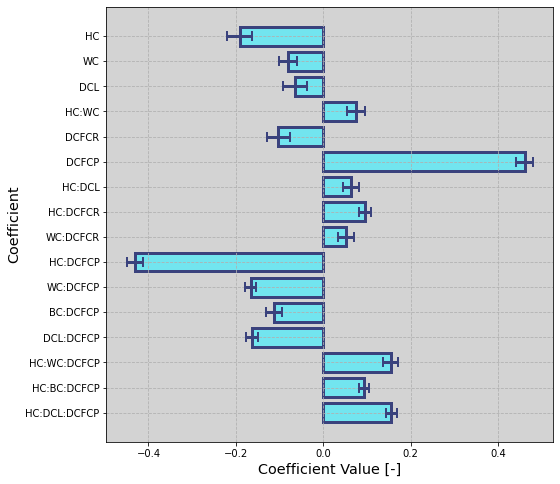

In [57]:
#Plotting significant model parameters
deep_reload(src)
fig=src.figures.SignificantParametersPlot(model,alpha=.01)

In [66]:
#Loading in AFDC data
deep_reload(src)
df_chargers=src.calculations.LoadAFDCData(lon=lon,lat=lat,radius=radius)

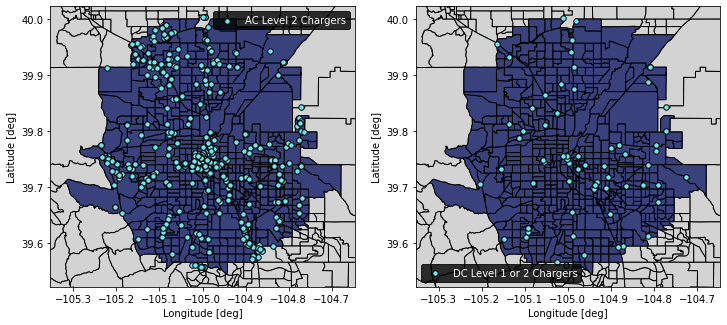

In [101]:
#Showing charger locations
deep_reload(src)
lon_ac_level_2=df_chargers[df_chargers['ev_level2_evse_num']>0]['longitude']
lat_ac_level_2=df_chargers[df_chargers['ev_level2_evse_num']>0]['latitude']
lon_dc_level_1_2=df_chargers[df_chargers['ev_dc_fast_num']>0]['longitude']
lat_dc_level_1_2=df_chargers[df_chargers['ev_dc_fast_num']>0]['latitude']
fig=src.figures.ComparisonDataScatterPlot(gdf_selected,gdf_background,
                                    lon_ac_level_2,lat_ac_level_2,
                                    lon_dc_level_1_2,lat_dc_level_1_2,
                                    data_1_label='AC Level 2 Chargers',
                                    data_2_label='DC Level 1 or 2 Chargers')

In [158]:
deep_reload(src)
bmdp=src.pull_data.BingMapsDataPuller(keys_dict['bing_maps_key'])
gdf_hex_data_res=bmdp.Pull_GDF(gdf_hex_data)

 56%|█████▌    | 1251/2254 [29:14<34:32,  2.07s/it] 

1250


100%|██████████| 2254/2254 [52:01<00:00,  1.38s/it]


In [159]:
#Saving Data
pkl.dump(gdf_hex_data_res,open('Data/Generated_Data/Resources_GDF.pkl','wb'))